In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from feature_selectors import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [184]:
gebruikers_df = pd.read_csv(r'..\..\data\gebruikersinformatie.csv', delimiter = ';')
evenement_df = pd.read_csv(r'..\..\data\evenementinformatie.csv', delimiter = ';')
aanwezigheid_df = pd.read_csv(r'..\..\data\evenementaanwezigheid.csv', delimiter = ';')

In [185]:
df = merge_on_aanwezigheid(aanwezigheid_df, evenement_df, gebruikers_df)

df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,e001,g123,bijgewoond,bbq,24-2-2023,g296,15-5-2023,11-12-2023,19.0,data engineering,eerstejaars,regulier
1,e001,g296,bijgewoond,bbq,24-2-2023,g296,6-9-2023,18-3-2024,22.0,security & cloud,eerstejaars,premium
2,e001,g032,geregistreerd,bbq,24-2-2023,g296,4-1-2023,19-5-2023,17.0,data engineering,tweedejaars,regulier
3,e001,g217,bijgewoond,bbq,24-2-2023,g296,13-8-2023,18-1-2024,24.0,data engineering,vierdejaars,regulier
4,e001,g162,geregistreerd,bbq,24-2-2023,g296,21-8-2023,8-5-2024,18.0,human computer interaction,tweedejaars,regulier
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,e040,g121,geregistreerd,workshop,19-2-2023,g215,15-10-2023,14-1-2024,24.0,human computer interaction,tweedejaars,premium
3428,e040,g170,afwezig,workshop,19-2-2023,g215,2-6-2023,2-6-2023,23.0,software engineering,derdejaars,premium
3429,e040,g141,bijgewoond,workshop,19-2-2023,g215,2-11-2023,18-4-2024,17.0,security & cloud,derdejaars,regulier
3430,e040,g176,geregistreerd,workshop,19-2-2023,g215,11-7-2023,15-8-2023,30.0,human computer interaction,tweedejaars,regulier


In [186]:
# Remove nonvalid entries
for col in df.columns:
    df = df[~(df[col].isna())]

df = df[~(df['Gebruiker_Lidmaatschapstype'] == 'x')]
df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,e001,g123,bijgewoond,bbq,24-2-2023,g296,15-5-2023,11-12-2023,19.0,data engineering,eerstejaars,regulier
1,e001,g296,bijgewoond,bbq,24-2-2023,g296,6-9-2023,18-3-2024,22.0,security & cloud,eerstejaars,premium
2,e001,g032,geregistreerd,bbq,24-2-2023,g296,4-1-2023,19-5-2023,17.0,data engineering,tweedejaars,regulier
3,e001,g217,bijgewoond,bbq,24-2-2023,g296,13-8-2023,18-1-2024,24.0,data engineering,vierdejaars,regulier
4,e001,g162,geregistreerd,bbq,24-2-2023,g296,21-8-2023,8-5-2024,18.0,human computer interaction,tweedejaars,regulier
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,e040,g121,geregistreerd,workshop,19-2-2023,g215,15-10-2023,14-1-2024,24.0,human computer interaction,tweedejaars,premium
3428,e040,g170,afwezig,workshop,19-2-2023,g215,2-6-2023,2-6-2023,23.0,software engineering,derdejaars,premium
3429,e040,g141,bijgewoond,workshop,19-2-2023,g215,2-11-2023,18-4-2024,17.0,security & cloud,derdejaars,regulier
3430,e040,g176,geregistreerd,workshop,19-2-2023,g215,11-7-2023,15-8-2023,30.0,human computer interaction,tweedejaars,regulier


In [187]:
# Convert ID to ints
to_convert = ["EvenementID", "GebruikerID", "Evenement_OrganisatorID"]

for col in to_convert:
    df[col] = df[col].str[1:].astype(int)

df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,1,123,bijgewoond,bbq,24-2-2023,296,15-5-2023,11-12-2023,19.0,data engineering,eerstejaars,regulier
1,1,296,bijgewoond,bbq,24-2-2023,296,6-9-2023,18-3-2024,22.0,security & cloud,eerstejaars,premium
2,1,32,geregistreerd,bbq,24-2-2023,296,4-1-2023,19-5-2023,17.0,data engineering,tweedejaars,regulier
3,1,217,bijgewoond,bbq,24-2-2023,296,13-8-2023,18-1-2024,24.0,data engineering,vierdejaars,regulier
4,1,162,geregistreerd,bbq,24-2-2023,296,21-8-2023,8-5-2024,18.0,human computer interaction,tweedejaars,regulier
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,geregistreerd,workshop,19-2-2023,215,15-10-2023,14-1-2024,24.0,human computer interaction,tweedejaars,premium
3428,40,170,afwezig,workshop,19-2-2023,215,2-6-2023,2-6-2023,23.0,software engineering,derdejaars,premium
3429,40,141,bijgewoond,workshop,19-2-2023,215,2-11-2023,18-4-2024,17.0,security & cloud,derdejaars,regulier
3430,40,176,geregistreerd,workshop,19-2-2023,215,11-7-2023,15-8-2023,30.0,human computer interaction,tweedejaars,regulier


In [188]:
# Factorize
to_factorize = ["Aanwezigheidsstatus", "Gebruiker_Lidmaatschapstype"]

for col in to_factorize:
    df[col], unique_values = pd.factorize(df[col])

    print(f"\n{col} numerics:")
    for i, value in enumerate(unique_values):
        print(f"{i} -> {value}")


df['Gebruiker_Lidmaatschapstype'] = df['Gebruiker_Lidmaatschapstype'].astype(bool)

# Factorize studiejaar with map
df["Gebruiker_Studiejaar"] = df["Gebruiker_Studiejaar"].map({
    "eerstejaars": 1,
    "tweedejaars": 2,
    "derdejaars": 3,
    "vierdejaars": 4
})

# Aanwezigheidsstatus (0 = aanwezig, 1 = afwezig)
df['Aanwezigheidsstatus'] = df['Aanwezigheidsstatus'].replace(2, 1).astype('bool', )

df


Aanwezigheidsstatus numerics:
0 -> bijgewoond
1 -> geregistreerd
2 -> afwezig

Gebruiker_Lidmaatschapstype numerics:
0 -> regulier
1 -> premium


,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementType,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studierichting,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype
0,1,123,False,bbq,24-2-2023,296,15-5-2023,11-12-2023,19.0,data engineering,1,False
1,1,296,False,bbq,24-2-2023,296,6-9-2023,18-3-2024,22.0,security & cloud,1,True
2,1,32,True,bbq,24-2-2023,296,4-1-2023,19-5-2023,17.0,data engineering,2,False
3,1,217,False,bbq,24-2-2023,296,13-8-2023,18-1-2024,24.0,data engineering,4,False
4,1,162,True,bbq,24-2-2023,296,21-8-2023,8-5-2024,18.0,human computer interaction,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,True,workshop,19-2-2023,215,15-10-2023,14-1-2024,24.0,human computer interaction,2,True
3428,40,170,True,workshop,19-2-2023,215,2-6-2023,2-6-2023,23.0,software engineering,3,True
3429,40,141,False,workshop,19-2-2023,215,2-11-2023,18-4-2024,17.0,security & cloud,3,False
3430,40,176,True,workshop,19-2-2023,215,11-7-2023,15-8-2023,30.0,human computer interaction,2,False


In [189]:
# Dummies from evenemnttype and studierichting
df = pd.concat([df, pd.get_dummies(df['Evenement_EvenementType'], prefix = 'Evenement_EvenementType')], axis = 1)
df = pd.concat([df, pd.get_dummies(df['Gebruiker_Studierichting'], prefix = 'Gebruiker_Studierichting')], axis = 1)
df.drop(columns = ['Evenement_EvenementType', 'Gebruiker_Studierichting'], axis = 1, inplace = True)

df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_EvenementDatum,Evenement_OrganisatorID,Gebruiker_RegistratieDatum,Gebruiker_LaatsteLogin,Gebruiker_Leeftijd,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype,Evenement_EvenementType_bbq,Evenement_EvenementType_hackathon,Evenement_EvenementType_lezing,Evenement_EvenementType_workshop,Gebruiker_Studierichting_data engineering,Gebruiker_Studierichting_human computer interaction,Gebruiker_Studierichting_security & cloud,Gebruiker_Studierichting_software engineering
0,1,123,False,24-2-2023,296,15-5-2023,11-12-2023,19.0,1,False,True,False,False,False,True,False,False,False
1,1,296,False,24-2-2023,296,6-9-2023,18-3-2024,22.0,1,True,True,False,False,False,False,False,True,False
2,1,32,True,24-2-2023,296,4-1-2023,19-5-2023,17.0,2,False,True,False,False,False,True,False,False,False
3,1,217,False,24-2-2023,296,13-8-2023,18-1-2024,24.0,4,False,True,False,False,False,True,False,False,False
4,1,162,True,24-2-2023,296,21-8-2023,8-5-2024,18.0,2,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,True,19-2-2023,215,15-10-2023,14-1-2024,24.0,2,True,False,False,False,True,False,True,False,False
3428,40,170,True,19-2-2023,215,2-6-2023,2-6-2023,23.0,3,True,False,False,False,True,False,False,False,True
3429,40,141,False,19-2-2023,215,2-11-2023,18-4-2024,17.0,3,False,False,False,False,True,False,False,True,False
3430,40,176,True,19-2-2023,215,11-7-2023,15-8-2023,30.0,2,False,False,False,False,True,False,True,False,False


In [190]:
# Convert columns to datetime datatype
date_columns = ['Evenement_EvenementDatum', 'Gebruiker_RegistratieDatum', 'Gebruiker_LaatsteLogin']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], dayfirst = True)

# Extract date/month/year from datetime columns
for col in date_columns:
    df[f'{col}_is_weekend'] = df[col].dt.weekday >= 5
    df[f'{col}_month'] = df[col].dt.month
    # df[f'{col}_year'] = df[col].dt.year

df.drop(columns = date_columns, inplace = True)

df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_OrganisatorID,Gebruiker_Leeftijd,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype,Evenement_EvenementType_bbq,Evenement_EvenementType_hackathon,Evenement_EvenementType_lezing,...,Gebruiker_Studierichting_data engineering,Gebruiker_Studierichting_human computer interaction,Gebruiker_Studierichting_security & cloud,Gebruiker_Studierichting_software engineering,Evenement_EvenementDatum_is_weekend,Evenement_EvenementDatum_month,Gebruiker_RegistratieDatum_is_weekend,Gebruiker_RegistratieDatum_month,Gebruiker_LaatsteLogin_is_weekend,Gebruiker_LaatsteLogin_month
0,1,123,False,296,19.0,1,False,True,False,False,...,True,False,False,False,False,2,False,5,False,12
1,1,296,False,296,22.0,1,True,True,False,False,...,False,False,True,False,False,2,False,9,False,3
2,1,32,True,296,17.0,2,False,True,False,False,...,True,False,False,False,False,2,False,1,False,5
3,1,217,False,296,24.0,4,False,True,False,False,...,True,False,False,False,False,2,True,8,False,1
4,1,162,True,296,18.0,2,False,True,False,False,...,False,True,False,False,False,2,False,8,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,True,215,24.0,2,True,False,False,False,...,False,True,False,False,True,2,True,10,True,1
3428,40,170,True,215,23.0,3,True,False,False,False,...,False,False,False,True,True,2,False,6,False,6
3429,40,141,False,215,17.0,3,False,False,False,False,...,False,False,True,False,True,2,False,11,False,4
3430,40,176,True,215,30.0,2,False,False,False,False,...,False,True,False,False,True,2,False,7,False,8


In [191]:
def get_all_predictors():
    all_predictors = df.columns.tolist()
    all_predictors.remove('EvenementID')
    all_predictors.remove('GebruikerID')
    all_predictors.remove('Evenement_OrganisatorID')

    return all_predictors

df

,EvenementID,GebruikerID,Aanwezigheidsstatus,Evenement_OrganisatorID,Gebruiker_Leeftijd,Gebruiker_Studiejaar,Gebruiker_Lidmaatschapstype,Evenement_EvenementType_bbq,Evenement_EvenementType_hackathon,Evenement_EvenementType_lezing,...,Gebruiker_Studierichting_data engineering,Gebruiker_Studierichting_human computer interaction,Gebruiker_Studierichting_security & cloud,Gebruiker_Studierichting_software engineering,Evenement_EvenementDatum_is_weekend,Evenement_EvenementDatum_month,Gebruiker_RegistratieDatum_is_weekend,Gebruiker_RegistratieDatum_month,Gebruiker_LaatsteLogin_is_weekend,Gebruiker_LaatsteLogin_month
0,1,123,False,296,19.0,1,False,True,False,False,...,True,False,False,False,False,2,False,5,False,12
1,1,296,False,296,22.0,1,True,True,False,False,...,False,False,True,False,False,2,False,9,False,3
2,1,32,True,296,17.0,2,False,True,False,False,...,True,False,False,False,False,2,False,1,False,5
3,1,217,False,296,24.0,4,False,True,False,False,...,True,False,False,False,False,2,True,8,False,1
4,1,162,True,296,18.0,2,False,True,False,False,...,False,True,False,False,False,2,False,8,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3427,40,121,True,215,24.0,2,True,False,False,False,...,False,True,False,False,True,2,True,10,True,1
3428,40,170,True,215,23.0,3,True,False,False,False,...,False,False,False,True,True,2,False,6,False,6
3429,40,141,False,215,17.0,3,False,False,False,False,...,False,False,True,False,True,2,False,11,False,4
3430,40,176,True,215,30.0,2,False,False,False,False,...,False,True,False,False,True,2,False,7,False,8


[False  True]


[Text(0.6666666666666666, 0.9, 'Evenement_EvenementDatum_is_weekend <= 0.5\ngini = 0.486\nsamples = 12\nvalue = [7, 5]\nclass = False'),
 Text(0.5, 0.7, 'Evenement_EvenementType_hackathon <= 0.5\ngini = 0.494\nsamples = 9\nvalue = [4, 5]\nclass = True'),
 Text(0.5833333333333333, 0.8, 'True  '),
 Text(0.3333333333333333, 0.5, 'Evenement_EvenementDatum_month <= 7.0\ngini = 0.408\nsamples = 7\nvalue = [2, 5]\nclass = True'),
 Text(0.16666666666666666, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = True'),
 Text(0.5, 0.3, 'Evenement_EvenementType_workshop <= 0.5\ngini = 0.48\nsamples = 5\nvalue = [2, 3]\nclass = True'),
 Text(0.3333333333333333, 0.1, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]\nclass = True'),
 Text(0.6666666666666666, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = False'),
 Text(0.6666666666666666, 0.5, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = False'),
 Text(0.8333333333333334, 0.7, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = False'),
 Text(

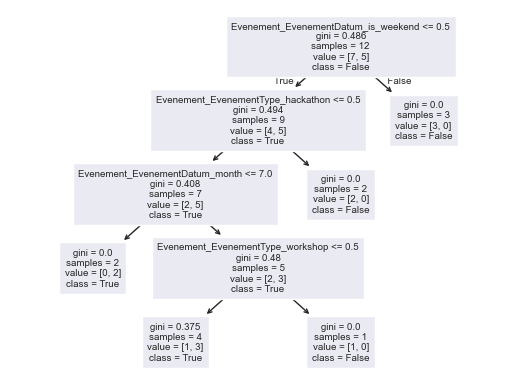

In [198]:
model = DecisionTreeClassifier(random_state=1, max_depth=4)
user_id = 1
all_predictors = get_all_predictors()
sub_df = df[df['GebruikerID'] == user_id]
X = sub_df[all_predictors].drop(columns=[col for col in sub_df.columns if col.startswith('Gebruiker_')], axis=1)
X.drop('Aanwezigheidsstatus', axis = 1, inplace = True)

Y = sub_df['Aanwezigheidsstatus']
tree = model.fit(X, Y)
print(tree.classes_)
plot_tree(tree, feature_names = X.columns, class_names = list(map(str, tree.classes_)), fontsize = 7)